<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#Dummy-модель-без-обучения-(предыдущее-значение-ряда)" data-toc-modified-id="Dummy-модель-без-обучения-(предыдущее-значение-ряда)-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Dummy-модель без обучения (предыдущее значение ряда)</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Цель исследования** - выполнить следующие задачи:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

**Ход исследования**

Данные лежат в файле `/datasets/taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»). О качестве данных нам ничего не известно. Значит перед анализом понадбится просмотреть данные. 

После подготовки данных займёмся обучением моделей. Опираясь на критерии заказчика, выберем лучшую модель и проверим её качество на тестовой выборке.

## Подготовка

In [1]:
#подключим необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
#прочитаем файл
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
#выведем первые 5 строк таблицы
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
#проверим, в хронологическом ли порядке расположены даты и время
#data = data.sort_index()
data.index.is_monotonic

True

In [5]:
#выведем общую информацию
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
#проверим колличество пропусков в %
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
num_orders,0.000000


In [7]:
#посмотрим на количество дубликатов
data.duplicated().sum()

26415

Удалять дубликаты мы не будем, ибо это повторяющиеся значения вызовов такси, а поскольку даты стали индексами, то это совсем не ошибка в данных.

**Вывод**

В каждой строке таблицы - данные о количестве заказов такси с разницей в 10 минут. Данные не нуждаются в преобработке, ибо находятся в отличном состоянии.

## Анализ

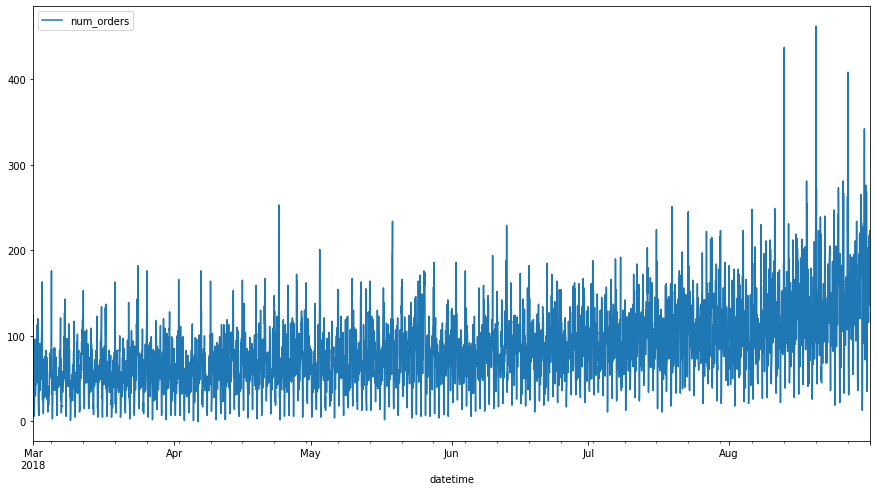

In [8]:
#выполним ресемплирование по 1 часу и построим график
data = data.resample('1H').sum()
data.plot(figsize=(15, 8))
plt.show()

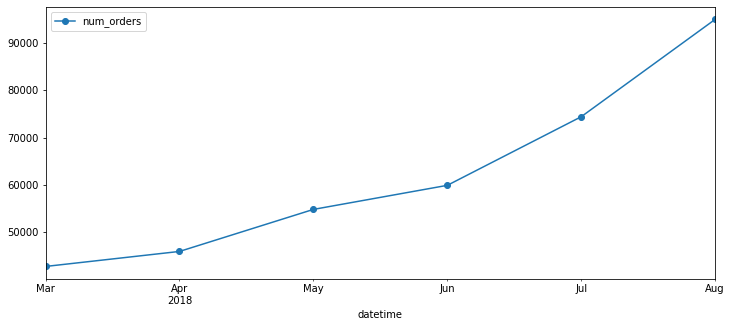

In [9]:
#посмотрим на данные по месяцам
data.resample('1M').sum().plot(style='o-', figsize=(12, 5))
plt.show()

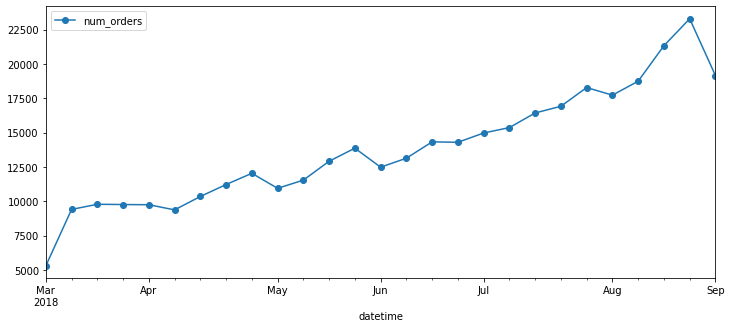

In [10]:
#посмотрим на данные по неделям
data.resample('1W').sum().plot(style='o-', figsize=(12, 5))
plt.show()

Чтобы лучше понять данные, посмотрим на тренды и сезонность

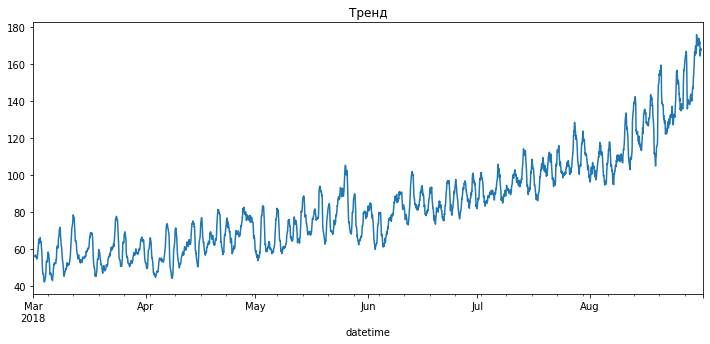

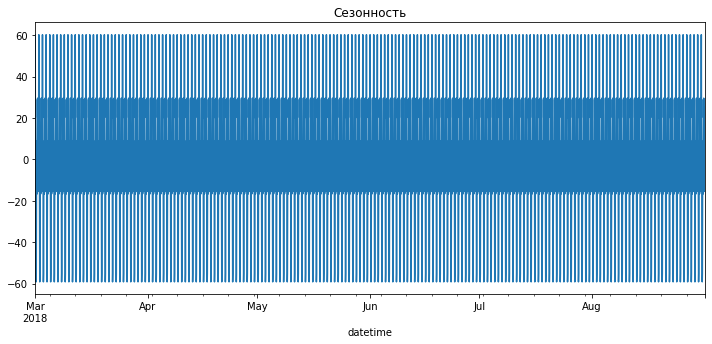

In [11]:
#глянем на сезонность и тренды, и построим графики
decomposed = seasonal_decompose(data)
decomposed.trend.plot(title='Тренд', figsize=(12, 5))
plt.show()
decomposed.seasonal.plot(title='Сезонность', figsize=(12, 5))
plt.show()

Посмотрим на сезонность и тренды по последней неделе

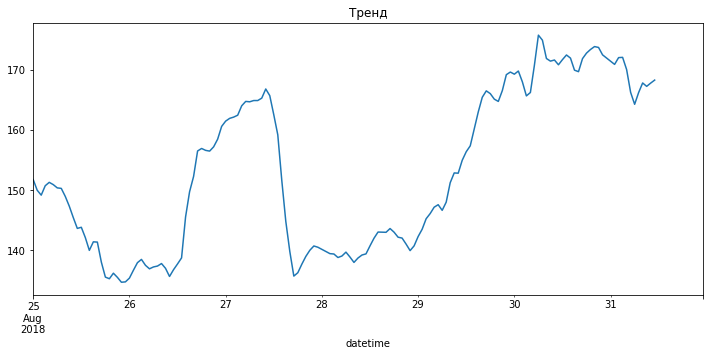

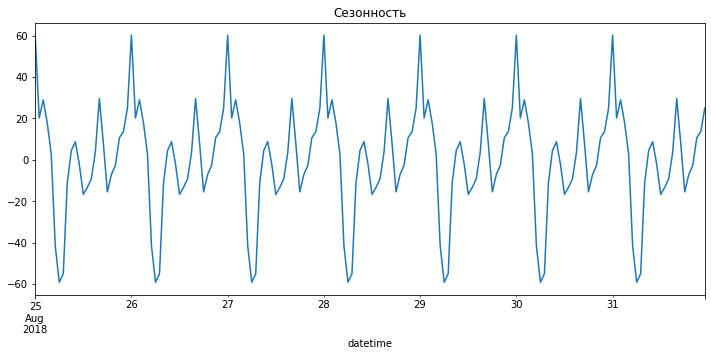

In [12]:
decomposed.trend['2018-08-25':'2018-08-31'].plot(title='Тренд', figsize=(12, 5))
plt.show()
decomposed.seasonal['2018-08-25':'2018-08-31'].plot(title='Сезонность', figsize=(12, 5))
plt.show()

Посмотрим на тренд и сезонность за две недели

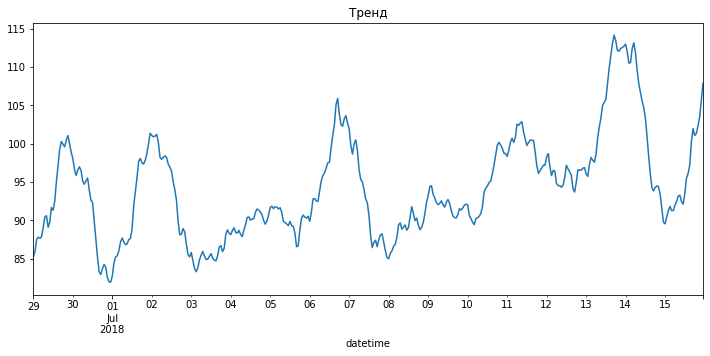

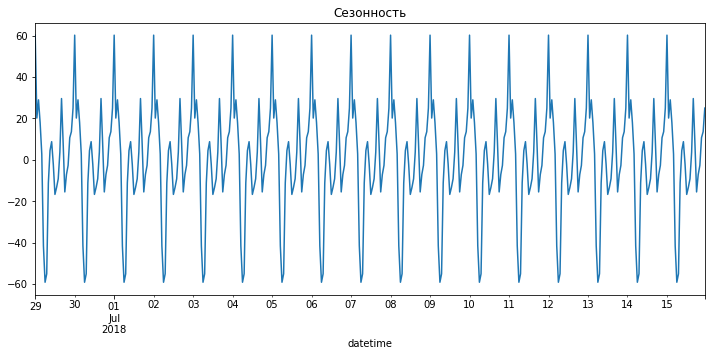

In [13]:
decomposed.trend['2018-06-29':'2018-07-15'].plot(title='Тренд', figsize=(12, 5))
plt.show()
decomposed.seasonal['2018-06-29':'2018-07-15'].plot(title='Сезонность', figsize=(12, 5))
plt.show()

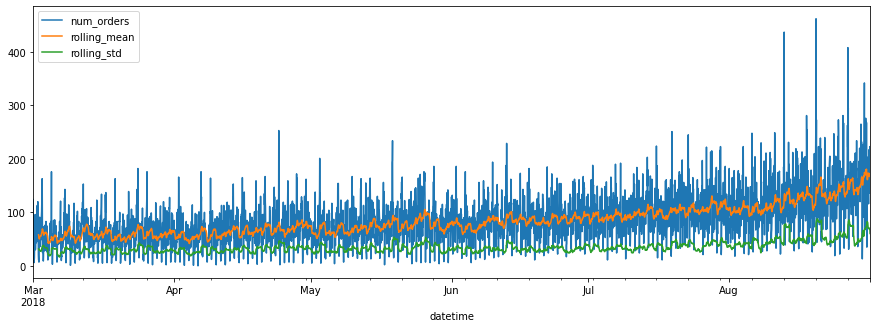

In [14]:
#посмотрим на скользящее среднее и стандартное отклонение
data['rolling_mean'] = data.rolling(30).mean()
data['rolling_std'] = data['num_orders'].rolling(30).std()
data.plot(figsize=(15, 5))
plt.show()

**Выводы**

Мы увидели следующее:

* По тренду и графикам(по неделям и месяцам) видно, что общее количество заказов такси увеличивается
* На графике сезонности за  последнюю неделю видно, что ночью заказов меньше, чем днём и вечером
* На графиках за две недели становится очевидно, что к началу выходных количество заказов увеличивается, а в воскресенье падает
* Стабильная сезонность подтверждает, что ночью заказов гораздо меньше


## Обучение

In [15]:
#создадим признаки
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
make_features(data, 10, 15)

In [16]:
#подготовим выборки
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
features_test = test.drop('num_orders', axis=1)
target_train = train['num_orders']
target_test = test['num_orders']

print('Размер обучающей выборки:', features_train.shape[0],'\n'
      'Размер тестовой выборки:', features_test.shape[0])

Размер обучающей выборки: 3945 
Размер тестовой выборки: 442


In [17]:
#проверим правильность данных
display(train.tail(2))
display(test.head(2))

,num_orders,rolling_mean,rolling_std,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
datetime,,,,,,,,,,,,,,,
2018-08-13 12:00:00,92,155.666667,74.857727,0,12,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0
2018-08-13 13:00:00,119,152.800000,72.230442,0,13,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0


,num_orders,rolling_mean,rolling_std,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
datetime,,,,,,,,,,,,,,,
2018-08-13 14:00:00,102,152.866667,72.152465,0,14,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0
2018-08-13 15:00:00,175,147.333333,72.412960,0,15,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0


Использовать будем следующие модели:

1. **LightGBMRegressor**
2. **LinearRegression**
3. **Dummy-модель без обучения** - предыдущее значение ряда

### LightGBM

In [18]:
#подберём гиперпараметры
depth = [3, 6, 9, 12]
leaves = [10, 20, 40, 60]
est = [50, 100, 150, 200]

for de, le, est in zip(depth, leaves, est):
    gbm = LGBMRegressor(max_depth=de, 
                        num_leaves=le, 
                        n_estimators=est)
    gbm.fit(features_train, target_train)
    predictions = gbm.predict(features_train)
    rmse = mean_squared_error(target_train, predictions)**0.5
    print(f'RMSE при: глубина {de}, кол-во листьев {le}, кол-во деревьев {est}, = {rmse}')    

RMSE при: глубина 3, кол-во листьев 10, кол-во деревьев 50, = 22.390306261308872
RMSE при: глубина 6, кол-во листьев 20, кол-во деревьев 100, = 17.021670890444547
RMSE при: глубина 9, кол-во листьев 40, кол-во деревьев 150, = 11.969890010281675
RMSE при: глубина 12, кол-во листьев 60, кол-во деревьев 200, = 8.208068806068553


### LinearRegression

In [19]:
lin = LinearRegression()
lin.fit(features_train, target_train)
predictions = lin.predict(features_train)
rmse_lin = mean_squared_error(target_train, predictions)**0.5
print('RMSE:', rmse_lin)

RMSE: 30.94888988700613


### Dummy-модель без обучения (предыдущее значение ряда)

In [ ]:
pred_previous = test.shift() 
pred_previous.iloc[0] = train.iloc[-1]
print('RMSE:', mean_squared_error(pred_previous, test)**0.5)

**Вывод**

LightGBM и LinearRegression мы проверяли непосредственно на обучающей выборке, а вот dummy-модель сразу проверяется на тестовой выборке. Dummy-модель мы сразу отбрасываем, ибо значение её RMSE слишком велико. 

LightGBM показало лучшее значение. Мы подобрали ей гиперпараметры, а значит можно приступать к тестированию

## Тестирование

In [21]:
gbm = LGBMRegressor(num_leaves=12, n_estimators=200, objective='regression')
gbm.fit(features_train, target_train)
predictions = gbm.predict(features_test)
rmse = mean_squared_error(target_test, predictions)**0.5
print('RMSE на тестовой выборке:', rmse)

RMSE на тестовой выборке: 41.845013031890986


Выведем на графиках реальное количество заказов и предсказанное моделью. 

Создадим 2 графика:
1. За весь период данных тестовой выборки
2. За несколько дней данных тестовой выборки

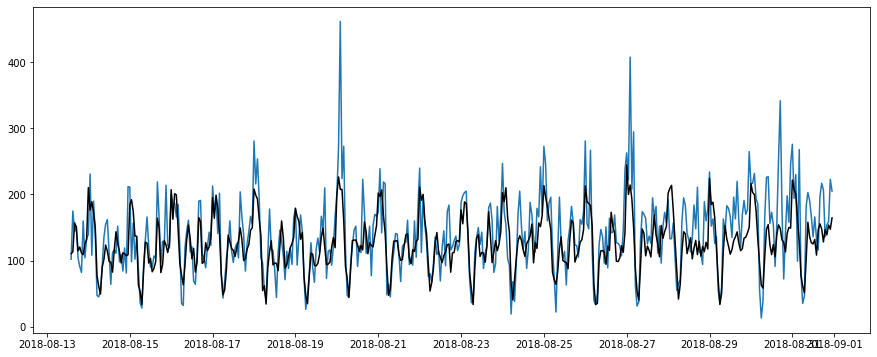

In [22]:
plt.figure(figsize=(15, 6))
plt.plot(target_test.index, target_test, target_test.index, predictions, 'black')
plt.show()

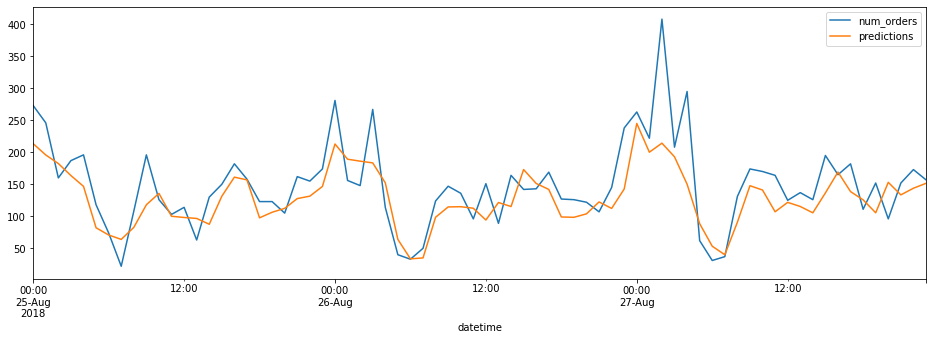

In [23]:
taxi_pred = pd.DataFrame(data = predictions, columns = ['predictions'], index = features_test.index)
data_pred = pd.merge(target_test, taxi_pred, left_index = True, right_index = True)
data_pred['2018-08-25':'2018-08-27'].plot(figsize=(16,5))
plt.show()

**Вывод**

Можно сделать вывод, что наша модель вполне успешна. По требованию заказчика RMSE не должно превышать 48, а наш RMSE = 41.84

По графиками можно сказать, что наша модель ± предсказывает правильно. Я абсолютно уверен, что предсказание может быть ещё лучше, если перебирать гиперпараметры дальше, либо попробовать совсем другие модели. 


## Общий вывод

В ходе работы мы:
1. Подготовили данные для анализа
2. Провели анализ данных
3. Подготовили признаки и разбили данные на выборки
4. Обучили модели
5. Провели тестирование на лучшей модели

Нам был предоставлен один файл с данными. Предобработка не понадобилась, ибо данные были в отличном состоянии. Во время анализа мы изучили сезонность и тренды, посмотрели на скользящее среднее и скользящее стандартное отклонение. 

После обучения мы пришли к выводу, что LightGBM показал себя лучше всех в этой задаче: RMSE = 41.84. По последним графикам видно, что модель вполне неплохо предсказывает, но я уверен, что её можно ещё лучше обучить.